## `Пишем веб-приложение`

Теперь всё готово, чтобы перейти к написанию самого сервера. 
Веб сервер будет иметь достаточно простое API c небольшм количестовом методов:

 - /predict основной POST - метод для получения породы по загруженной фотограмм
 - /breeds GET - метод, чтобы получить доступные породы

Сделаем все необходимые импорты

In [235]:
%%writefile flask_dogs_classifier.py

import base64
import io
import os
import json
import torch 

from flask import Flask, jsonify, abort, request, make_response, url_for
from PIL import Image
from torchvision import transforms

Overwriting flask_dogs_classifier.py


#### `DL-модель`

Подготовим специальный класс DL-модели под нашу задачу. Цель данного класса произвести необходиыме преобразования входного изображения, сделать feedforward шаг, после чего вернуть название породы человекочитаемом формате.

In [236]:
%%writefile -a flask_dogs_classifier.py

IMAGE_SIZE = 224
MODEL_RESOURCES_DIR = 'models'

class DogsClassifier:


    def __init__(self, model_type, model_dict, index_mapper):
        self._index_mapper = index_mapper
        self._model = self._create_model_from(model_dict)
        self._model_transform = self._create_model_transform(model_type)

    @property
    def available_classes(self):
        return list(self._index_mapper.values())

    @staticmethod
    def _create_model_from(model_dict):
        model = model_dict['model']
        model.load_state_dict(model_dict['state_dict'])
        for parameter in model.parameters():
            parameter.requires_grad = False

        model.eval()
        return model
        
    @staticmethod
    def _create_model_transform(model_type):
        if model_type == 'resnet':
            return transforms.Compose(
                [ transforms.Resize(IMAGE_SIZE),
                  transforms.CenterCrop(IMAGE_SIZE),
                  transforms.ToTensor(),
                  transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]
                    )
                ]
            )
                        
        raise KeyError(f"{model_type} is not supported")


    @classmethod
    def create_from(cls, model_directory) -> 'DogsClassifier':
        
         model_dict = torch.load(os.path.join(model_directory, 'finetuned_model.pth'))
         with open(os.path.join(model_directory, 'breeds_mapping.json')) as fin:
            index_mapper = json.load(fin) 
            index_mapper = {int(key): val for key, val in index_mapper.items()}
             
            return cls('resnet', model_dict, index_mapper)


    def __call__(self, image):
        
        transformed_image = self._model_transform(image)
        model_input = transformed_image[None, ...]
        outputs = self._model(model_input)
        _, preds = torch.max(outputs.data, 1)
        print(self._index_mapper, preds[0], int(preds[0]))
        breed_str = self._index_mapper[int(preds[0])]

        return breed_str
    

Appending to flask_dogs_classifier.py


#### `Веб-приложение`

Теперь перейдём непосредственно к написанию самого сервиса

In [237]:
%%writefile -a flask_dogs_classifier.py

from flask import Flask, jsonify, abort, request, make_response, url_for

app = Flask(__name__)
ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg'])


@app.route('/breeds', methods=['GET'])
def get_breeds():
    return app.model.available_classes


@app.route('/predict', methods=['POST'])
def make_prediction():
    if 'encoded_image' not in request.json:
        abort(400, 'Not found image')
        
    encoded_image = request.json['encoded_image']
    image_bytes = base64.b64decode(encoded_image)
    image = Image.open(io.BytesIO(image_bytes))

    dog_breed = app.model(image)
    return {'breed': dog_breed}


if __name__ == '__main__':
    app.model = DogsClassifier.create_from(MODEL_RESOURCES_DIR)
    app.run(host="0.0.0.0", port=5000)

Appending to flask_dogs_classifier.py


#### `Контейнеризуем наше приложение`

Соберём Docker образ с нашим сервисом. Для этого подготовим Dockerfile, в котором опишем все необходимые шаги.

In [246]:
from IPython.display import Code
Code('./Dockerfile', language='Dockerfile')

FROM python:3.10-slim

WORKDIR /app
COPY ./requirements.txt /app/requirements.txt

RUN pip3 install -r requirements.txt 

COPY . /app

EXPOSE 5000

ENTRYPOINT ["python3", "flask_dogs_classifier.py"]

#### `Проверка работоспособности сервиса`

In [239]:
import base64
import requests

from PIL import Image

Посмотрим, какие породы умеет определять обученная модель

In [240]:
response = requests.get(url="http://localhost:5000/breeds")
response.json()

['afghan_hound',
 'airedale',
 'australian_terrier',
 'basenji',
 'beagle',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'cairn',
 'entlebucher',
 'great_pyrenees',
 'irish_wolfhound',
 'japanese_spaniel',
 'leonberg',
 'maltese_dog',
 'miniature_pinscher',
 'pomeranian',
 'samoyed',
 'scottish_deerhound',
 'shih-tzu',
 'tibetan_terrier']

А теперь попробуем на какой-либо фотографии посмотреть его работу

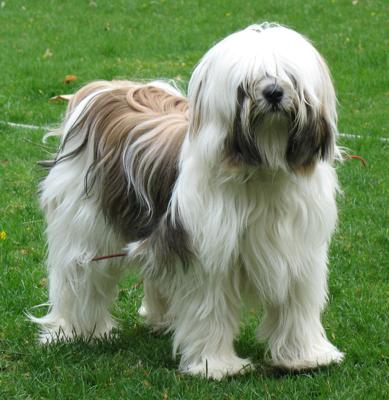

In [241]:
im = Image.open("photo_example.jpeg")
im

In [242]:
with open("photo_example.jpeg", 'rb') as img:
    encoded_image = base64.b64encode(img.read()).decode('utf-8')

In [243]:
response = requests.post(url="http://127.0.0.1:5000/predict", json={'encoded_image': encoded_image})

In [244]:
print(response.status_code)
response.json()

200


{'breed': 'tibetan_terrier'}

Подготовим Dockerfile с образом нашего сервиса и запустим его

In [3]:
from IPython.display import Code

Code('./Dockerfile', language='Dockerfile')

# Используем в качестве базового образа образ Python
FROM python:3.10-slim

# Создадим внтури контейнера директорию app
WORKDIR /app
COPY ./requirements.txt /app/requirements.txt

# Установим в контейнере все необходимые зависимости
RUN pip3 install -r requirements.txt 

# Перекопируем всё содержимое текущей папки внутрь папки контейнера /app
COPY . /app

# Устанавливаем порт, на котором будет работать приложение
EXPOSE 5000

# Команда, которая запустится при docker run
ENTRYPOINT ["python3", "flask_dogs_classifier.py"]